In [1]:
import glob 
import numpy as np 
import os 
import shutil 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model 
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers  

In [2]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        

In [3]:
IM_SHAPE=(225,225)
input_shape=(IM_SHAPE[0],IM_SHAPE[1],3)

In [4]:
batch_size = 32
num_classes = 2 
epochs = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.2)

# train_generator = train_datagen.flow_from_directory(
#     '../input/covidog/dataset',
#     target_size=IM_SHAPE,

#     batch_size=batch_size,
#     class_mode='categorical') # set as training data

train_generator_NEW = train_datagen.flow_from_directory(
    '../input/covidnew/ALL', # same directory as training data
    target_size=IM_SHAPE,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
validation_generator_NEW= train_datagen.flow_from_directory(
    '../input/covidnew/ALL',
#     batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)
test_generator_NEW=val_datagen.flow_from_directory(
    '../input/covidnew/ALL',
    #batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)

Found 15861 images belonging to 2 classes.
Found 6796 images belonging to 2 classes.
Found 4531 images belonging to 2 classes.


In [5]:
#from keras.applications import DenseNet121

from keras.applications import vgg16 
vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

#vgg_model.summary()

2023-01-25 23:57:45.770717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 23:57:45.873283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 23:57:45.874172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 23:57:45.875854: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [6]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fe5aecc3ad0>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7fe5ae87f9d0>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7fe5acb00590>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7fe5ac047990>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7fe5ac041e50>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7fe5ac190dd0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fe5ac0416d0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7fe5ac1639d0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7fe5ac18d050>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7fe5ac18d190>,block3_conv3,False


In [7]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


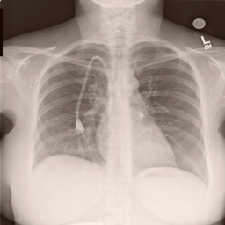

In [8]:
array_to_img(train_generator_NEW[0][0][0])

2023-01-25 23:57:50.021643: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-25 23:57:51.040517: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 7, 7, 512)


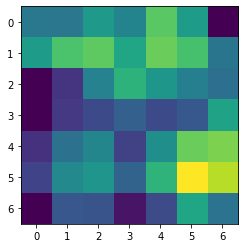

In [9]:
bottleneck_feature_example = vgg.predict(train_generator_NEW[0][0])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [18]:
model_TF = Sequential() 

model_TF.add(vgg_model) 
model_TF.add(Dense(1024, activation='relu')) 
model_TF.add(Dropout(0.25)) 
model_TF.add(Dense(512, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(256, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(num_classes, activation='sigmoid'))

model_TF.summary()

model_TF.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 25088)             14714688  
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)              

In [19]:
# history_TF = model_TF.fit(train_generator_NEW, 
#                               epochs=15,  
#                               validation_data=validation_generator_NEW,  
#                               verbose=1)

In [20]:
history_TF = model_TF.fit_generator(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


496/496 [==============================] - 171s 342ms/step - loss: 0.4268 - accuracy: 0.8026 - f1_m: 0.7751 - precision_m: 0.7849 - recall_m: 0.7726 - val_loss: 0.2121 - val_accuracy: 0.9233 - val_f1_m: 0.9196 - val_precision_m: 0.9359 - val_recall_m: 0.9043
Epoch 2/15
496/496 [==============================] - 84s 169ms/step - loss: 0.2797 - accuracy: 0.8863 - f1_m: 0.8821 - precision_m: 0.8791 - recall_m: 0.8863 - val_loss: 0.1941 - val_accuracy: 0.9216 - val_f1_m: 0.9220 - val_precision_m: 0.9192 - val_recall_m: 0.9249
Epoch 3/15
496/496 [==============================] - 81s 163ms/step - loss: 0.2415 - accuracy: 0.9033 - f1_m: 0.9028 - precision_m: 0.9004 - recall_m: 0.9059 - val_loss: 0.1767 - val_accuracy: 0.9303 - val_f1_m: 0.9273 - val_precision_m: 0.9327 - val_recall_m: 0.9222
Epoch 4/15
496/496 [==============================] - 80s 160ms/step - loss: 0.2886 - accuracy: 0.8838 - f1_m: 0.8787 - precision_m: 0.8898 - recall_m: 0.8685 - val_loss: 0.2415 - val_accuracy: 0.8949 - 

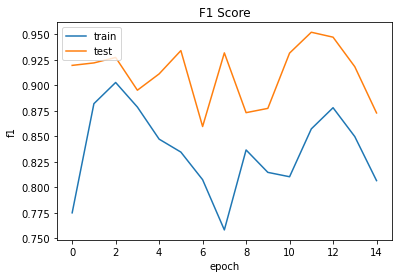

In [21]:
plt.plot(history_TF.history['f1_m'])
plt.plot(history_TF.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
test_loss= model_TF.evaluate(test_generator_NEW, verbose=1)

142/142 [==============================] - 18s 127ms/step - loss: 0.3146 - accuracy: 0.8735 - f1_m: 0.8741 - precision_m: 0.8729 - recall_m: 0.8753


In [23]:
test_loss

[0.3145766258239746,
 0.8735378384590149,
 0.874068558216095,
 0.8728994727134705,
 0.8752895593643188]

In [24]:
dense = vgg16.VGG16(include_top=False,
                                     input_shape=input_shape) 
output = dense.layers[-1].output 
output = keras.layers.Flatten()(output) 
dense_model = Model(dense.input, output) 
dense_model.trainable = True


In [25]:
model = Sequential() 

model.add(dense_model) 
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.25)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid'))



model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [26]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 25088)             14714688  
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)              

In [27]:
history = model.fit_generator(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15
496/496 [==============================] - 133s 263ms/step - loss: 0.2548 - accuracy: 0.8936 - f1_m: 0.8849 - precision_m: 0.8564 - recall_m: 0.9183 - val_loss: 0.0922 - val_accuracy: 0.9672 - val_f1_m: 0.9677 - val_precision_m: 0.9648 - val_recall_m: 0.9708
Epoch 2/15
496/496 [==============================] - 129s 259ms/step - loss: 0.1074 - accuracy: 0.9625 - f1_m: 0.9595 - precision_m: 0.9529 - recall_m: 0.9667 - val_loss: 0.0578 - val_accuracy: 0.9800 - val_f1_m: 0.9799 - val_precision_m: 0.9795 - val_recall_m: 0.9803
Epoch 3/15
496/496 [==============================] - 130s 262ms/step - loss: 0.0721 - accuracy: 0.9748 - f1_m: 0.9726 - precision_m: 0.9664 - recall_m: 0.9791 - val_loss: 0.0743 - val_accuracy: 0.9735 - val_f1_m: 0.9735 - val_precision_m: 0.9713 - val_recall_m: 0.9758
Epoch 4/15
496/496 [==============================] - 129s 259ms/step - loss: 0.0530 - accuracy: 0.9822 - f1_m: 0.9801 - precision_m: 0.9749 - recall_m: 0.9856 - val_loss: 0.0561 - val_accur

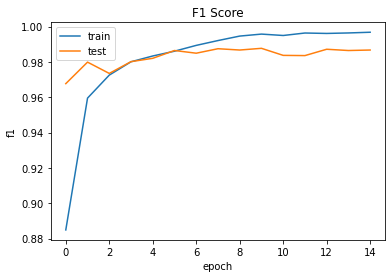

In [28]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
test_loss= model.evaluate(test_generator_NEW, verbose=1)

142/142 [==============================] - 16s 113ms/step - loss: 0.0627 - accuracy: 0.9857 - f1_m: 0.9851 - precision_m: 0.9835 - recall_m: 0.9868


In [30]:
test_loss

[0.06274640560150146,
 0.985654354095459,
 0.9851028919219971,
 0.9834672212600708,
 0.9867957830429077]